In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%config IPCompleter.greedy=True

https://automatetheboringstuff.com/chapter17/

https://docs.opencv.org/3.4.3/dc/dbb/tutorial_py_calibration.html

The objective of this doc is to create learning data so that we can recognize:
* position of an object
* has the object got one or more parallel edges
* if there are parallel edges, what is the rotation of the longest parallel set

a set parallel edges are parallel if:
* parallelism within certain angle

rotation is:
* a number between 0 and 180 degrees

The scheme will be as follows:

create a region with 4 edges
inputs:
* amount of pictures
* max angle to be considered still parallel (in degrees)

then:
* create a new image
* rotate the region
* paste the region onto the image
* save the image -> directory

append in labels file:
* image file name 
* has_more_than_zero_parallel_sets
* center_x
* center_y
* rotation

What to do with corner cases, like squares?
* Let's ignore squares for now

In [2]:
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [3]:
import numpy as np
np.random.seed(9)
np.random.random()

0.010374153885699955

In [4]:
np.random.seed(None)

In [102]:
# define the variables for our images
img_w = 600
img_l = 400

# max angle considered parallel
max_angle = 2
# upper boundary for generating non-paralellism
variation_max = 30
# some base parameters for shapes
width_min = 40
width_max = 80
var_x = 10
# we do not make square regions for now
# the longer side:
# - should be at least 10 pixels longer
# - lenght with a max of 200% of the shorter side
long_side_fact_max = 2
long_side_addition = 20
# the position should also have a variance
max_var_x = 20
max_var_y = 10
max_rotation = 180

In [83]:
# generate nominal width and length
def generate_rect(width_max, width_min, long_side_fact_max, long_side_addition):
    width_var = width_max - width_min
    rect_width = width_min + (np.random.random() * width_var) 
    rect_length = rect_width + long_side_addition + ((np.random.random() * rect_width * long_side_fact_max))
    return rect_width, rect_length

w,l = generate_rect(width_max, width_min, long_side_fact_max, long_side_addition)
print('w = %s' % w)
print('l = %s' % l)


w = 41.30780691667215
l = 134.21031368309593


In [84]:
# create a point class
class point(object):
    def __init__(self, px, py):
        self.x = px
        self.y = py
    
    def coordinates(self):
        return self.x, self.y

# create four_sides class
# we draw a rectangle on its side
class four_sides(object):
    def __init__(self, w, l):
        self.w = w
        self.l = l
        # from quadr 3 -> 4 -> 1 -> 2
        self.p1 = point(-l/2, -w/2)
        self.p2 = point(l/2, -w/2)
        self.p3 = point(l/2, w/2)
        self.p4 = point(-l/2, w/2)
    
    # var_max will be used for changing the long sides
    # of the rectangle to a non_parallel shape
    #
    # thresh_par is the threshold under which we consider
    # the two sides parallel
    #
    # we always modify the lowest edge in length with a
    # minimal value of thresh_par so that our two side edges
    # are defenitely not parallel
    def modify(self, var_max, var_x):
        # extend lowest edge
        self.p1.x -= (1 + np.random.random()) * (var_x / 2)
        self.p2.x += (1 + np.random.random()) * (var_x / 2)
        self.p3.y += (2 * (0.5 - np.random.random())) * (var_max / 2)
        self.p4.y += (2 * (0.5 - np.random.random())) * (var_max / 2)
    
    def calc_parallel(self, thresh_ang):
        # we only modified the top edge in y-direction
        self.angle = self.calc_angle()
        if (abs(self.angle) < thresh_ang):
            self.is_parallel = True
        else:
            self.is_parallel = False
        return self.is_parallel
    
    def calc_angle(self):
        # we only modify the top edge in y-direction
        dy = self.p4.y - self.p3.y
        dx = self.p4.x - self.p3.x
        return -(math.atan(dy/dx))*(180/math.pi)
        
    def get_circumference(self):
        list_circ = [ self.p1.coordinates(),
                     self.p2.coordinates(),
                     self.p3.coordinates(),
                     self.p4.coordinates()]
        return list_circ

In [85]:
def draw_shape(shape, w, l):
    rect_back = Image.new('RGBA', (w, l), (0,0,0,0))
    mid_w = w / 2
    mid_h = l / 2

    drw = ImageDraw.Draw(rect_back)
    
    # get the circumference
    reg = shape.get_circumference()
    # shift to the center
    circ = []
    for p in reg:
        # print(p)
        px, py = p
        px += mid_w
        py += mid_h
        circ.append((px, py))
    # randomize colours 
    drw.polygon(circ, fill=(np.random.randint(150, 200), np.random.randint(150, 200), np.random.randint(150, 200), 255))
    del drw
    return rect_back


-47.41840012911113
35.31070832226335
48.58673619309916
-6.674138166080622
False


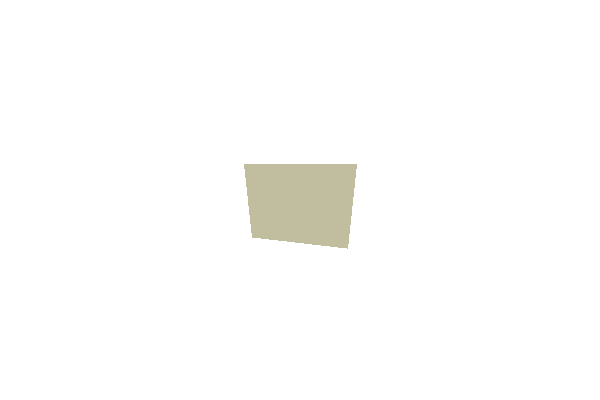

In [86]:
# generate dimensions
w,l = generate_rect(width_max, width_min, long_side_fact_max, long_side_addition)

# instantiate a thingy
thingy = four_sides(w, l)
print(thingy.p1.x)
print(thingy.p3.y)

# do magic modification
thingy.modify(variation_max, var_x)
print(thingy.p3.y)

print(thingy.calc_angle())

print(thingy.calc_parallel(max_angle))
draw_shape(thingy, img_w, img_l)

-80.8580215150151
-87.53215968109572


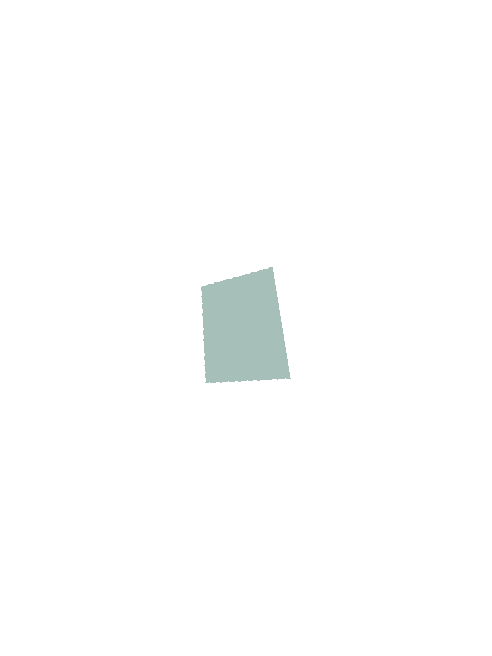

In [87]:
rotation = (0.5 - np.random.random()) * max_rotation
img = draw_shape(thingy, img_w, img_l)
rotated_shape = img.rotate(rotation, expand=True)
print(rotation)
print(rotation + thingy.angle)
rotated_shape

In [98]:
# we now have randomized shapes, with randomized rotations
# let's create the image, with a cackground and 
# paste them on top of that background

class shape_img(object):
    def __init__(self, w, l):
        min_grey_val = 100
        grey_val = np.random.randint(0, min_grey_val)
        self.img = Image.new('RGBA', (w, l), (grey_val,grey_val,grey_val,255))
        self.scale = 0
    
    def paste(self, im):
        # vary x and y position
        var_x = 50 + (0.5 - np.random.random()) * self.scale
        var_y = 50 - (0.5 - np.random.random()) * self.scale
        self.img.paste(im, (int(var_x), int(var_y)) , im)
        return var_x, var_y
        
    def get_img(self):
        return self.img
    
    def set_random_scale(self, scale):
        self.scale = scale

49.69675220427464
48.85233586949849


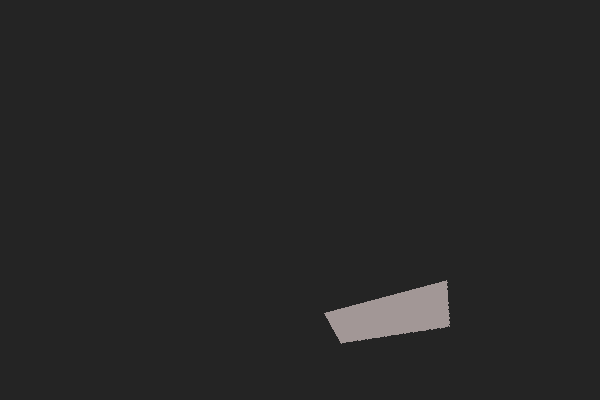

In [95]:
test = shape_img(img_w, img_l)
test.set_random_scale(10)
x_var, y_var = test.paste(rotated_shape)
print(x_var)
print(y_var)
test.img
#img.get_img()

In [176]:
def create_sample(filename, filetype):
    w,l = generate_rect(width_max, width_min, long_side_fact_max, long_side_addition)

    # instantiate a thingy
    thingy = four_sides(w, l)
    # do magic modification
    thingy.modify(variation_max, var_x)
    # get rotation of long side and if the shape has parallel sides
    rot_angle = thingy.calc_angle() / 2
    if int(thingy.calc_parallel(max_angle)) == 1:
        parallel = 'yes'
    else:
        parallel = 'no'
    # create random rotation
    pic_rotation = (0.5 - np.random.random()) * max_rotation
    # Total angle of rotation between centerline of long sides
    angle_z = pic_rotation + rot_angle
    
    # create the shape image
    img = draw_shape(thingy, img_w, img_l)
    rotated_shape = img.rotate(pic_rotation, expand=False)
    
    # create the base image on which to paste the shape
    picture = shape_img(img_w + 100, img_l + 100)
    picture.set_random_scale(10)
    x_var, y_var = picture.paste(rotated_shape)
    pict = picture.get_img()
    
    pict.thumbnail((pict.width/4, pict.height/4))
    
    # filename
    if filetype == 'JPEG':
        rgb_im = pict.convert('RGB')
        rgb_im.save(filename)
    else:
        pict.save(filename)
    return pict, parallel, angle_z, x_var, y_var


In [175]:
path_base = 'parallel_images_data'
path_train = 'images_jpg'


# define the variables for our images
img_w = 2400
img_l = 1600

# max angle considered parallel
max_angle = 2
# upper boundary for generating non-paralellism
variation_max = 60
# some base parameters for shapes
width_min = 160
width_max = 320
var_x = 40
# we do not make square regions for now
# the longer side:
# - should be at least 10 pixels longer
# - lenght with a max of 200% of the shorter side
long_side_fact_max = 2
long_side_addition = 80
# the position should also have a variance
max_var_x = 80
max_var_y = 40
max_rotation = 180

file_iter = 0
file_labels = path_base + '\\labels_png.csv'

# uncomment to generate new data

#with open(file_labels, 'w') as f:
#    f.write('filename,has_parallel_sides,angle_z,pos_x,pos_y\n')
    
#f.close()

#extension = '.png'
#filetype = 'PNG'
#pictures = 4000
#for pic in range(0,pictures):
#    f_name = path_base + '\\' + path_train + '\\' + str(pic) + extension
#    f_path = path_train + '\\' + str(pic) + extension
#    randimg, p, a, x, y = create_sample(f_name, filetype)
#    with open(file_labels, 'at') as f2:
#         f2.write('%s,%s,%s,%s,%s\n' % (f_path, p, a, x, y))

#f2.close

<function TextIOWrapper.close()>

parallel_images_data\test2.jpg
no 20.834616415985423 51.98530105318729 50.98555196689695


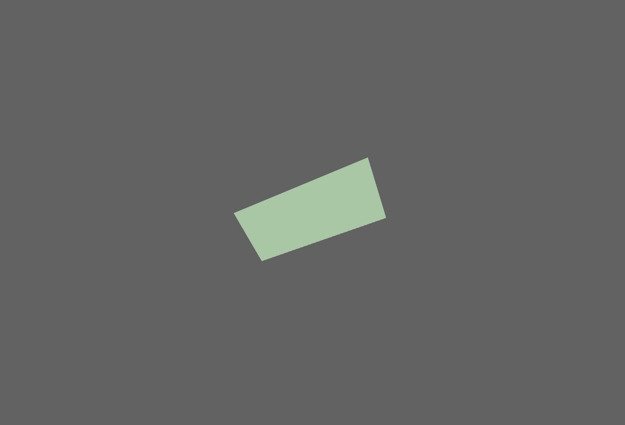

In [177]:
# for creating one single random image
extension = '.png'
filetype = 'PNG'

f_n = path_base + '\\test2' + extension
print(f_n)
gen_rand_img, p, a, x, y = create_sample(f_n, filetype)
print (p, a, x, y)
gen_rand_img